In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist

from util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

c:\users\user\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 50
sizeBatch = 32
dimInter = 64
dimEncode = 2
factNoise = 0.2
nameOptim = 'adam'

## Load the datasets

In [3]:
(xTrain, _), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


## Construct the encoder and decoder

In [4]:
layEncInt = Dense(dimInter, activation='relu')
layEncode = Dense(dimEncode, activation='relu')
layDecInt = Dense(dimInter, activation='relu')
layDecode = Dense(dimInput, activation='sigmoid')

inputs = Input(shape=(dimInput,))
interEncode = layEncInt(inputs)
latent = layEncode(interEncode)
encoder = Model(inputs, latent)

inputLatent = Input(shape=(dimEncode,))
interDecode = layDecInt(inputLatent)
outputs = layDecode(interDecode)
decoder = Model(inputLatent, outputs)

## Construct the autoencoder

In [5]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 50370     
_________________________________________________________________
model_2 (Model)              (None, 784)               51152     
Total params: 101,522
Trainable params: 101,522
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
autoencoder.compile(optimizer=nameOptim, loss='binary_crossentropy')
tic = time()
history = autoencoder.fit(xTrainNoise, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 136us/step - loss: 0.2472 - val_loss: 0.2736
Epoch 2/50
60000/60000 [==============================] - 6s 107us/step - loss: 0.2154 - val_loss: 0.2397
Epoch 3/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.2105 - val_loss: 0.2230
Epoch 4/50
60000/60000 [==============================] - 6s 107us/step - loss: 0.2074 - val_loss: 0.2192
Epoch 5/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.2053 - val_loss: 0.2162
Epoch 6/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.2038 - val_loss: 0.2123
Epoch 7/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.2027 - val_loss: 0.2093
Epoch 8/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.2017 - val_loss: 0.2083
Epoch 9/50
60000/60000 [==============================] - 6s 105us/step - loss: 0.2007 - val_loss: 0.2

## Show the historical training progress 

traing consumed: 321.0923409461975 seconds


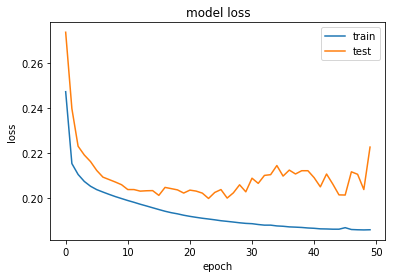

In [7]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

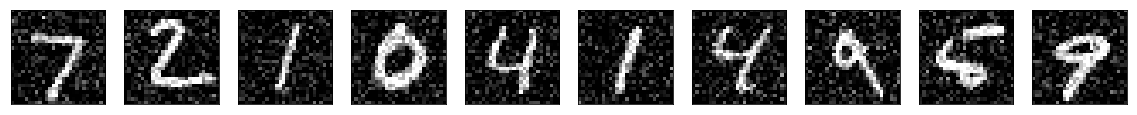

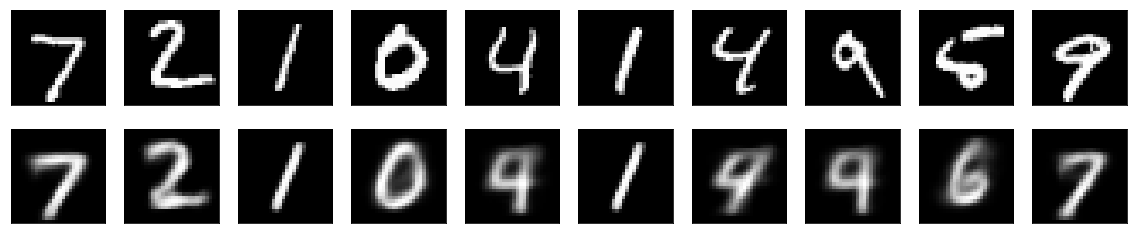

In [9]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

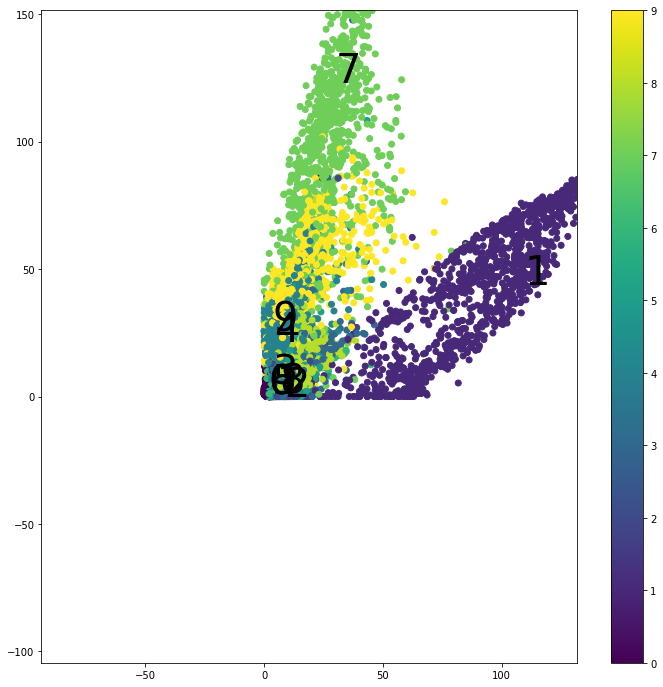

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

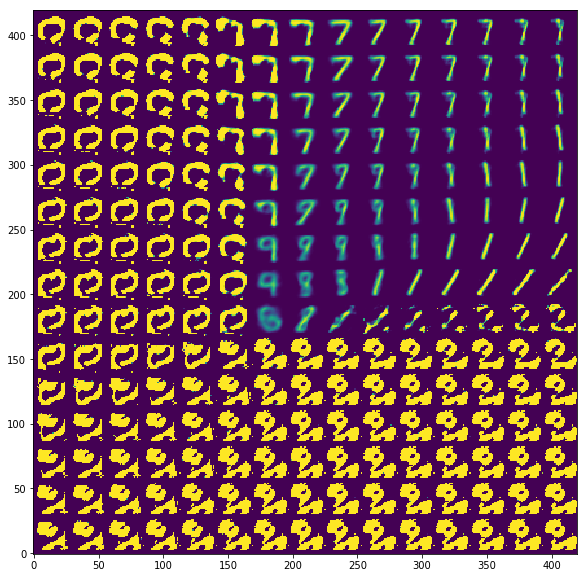

In [12]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

In [13]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

321.0923409461975 0.18601512188911437 0.2226608892440796 -0.029653816


In [15]:
np.save("../test/yTest_mnist",yTest)